# First pass at exploring Twitter scraping
- used tweepy to scrape the data & output json file 

In [79]:
from pymongo import MongoClient
import json
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import time

### organize data

In [80]:
#  import data 
with open('raw_tweets10min.json') as data_file:    
    data = json.load(data_file)

#  extract indices in 'data' for tweets that have fields of interest
i = 0
storei = []
storet = []
numTweets = len(data)
# numTweets = 10
while i < numTweets:
    temp = data[i]
    if "text" in temp:
        if temp["text"] == None:
            x = 1
        else:
            storet.append(i)
    if "coordinates" in temp:
        if temp["coordinates"] == None:
            x = 1
        else:
#             print(temp["coordinates"])            
            storei.append(i)
#     print(temp["geo"])
    i = i + 1

print('N coordinates:',len(storei), 'N Tweets', len(storet))

N coordinates: 16 N Tweets 28753


In [81]:
#  using the indices selected above, extract the relevant data into lists
coords = []
i = 0
while i < len(storei):
#     print(i)
    coords.append(data[storei[i]]["coordinates"]["coordinates"])
    i = i + 1
    
texts = []
t = 0
while t < len(storet):
#     print(i)
    texts.append(data[storet[t]]["text"])
    t = t + 1
    

## Plot geographical coordinates of tweets

In [82]:
# This just lets the output of the following code samples
#  display inline on this page, at an appropriate size.
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10,20)

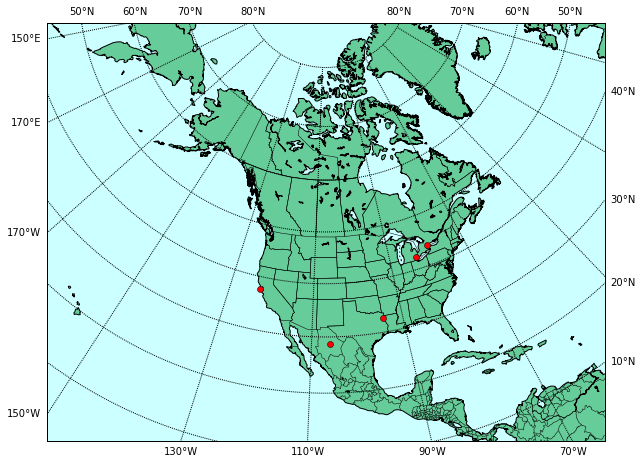

In [108]:
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(projection='lcc',width=12000000,height=9000000,
            resolution='l',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
#draw boundary, fill ocean color
m.drawmapboundary(fill_color='#CCFFFF')
# fill continents, set lake color
m.fillcontinents(color='#66CC99',lake_color='#CCFFFF') # '#6699CC'
# draw parallels and meridians. label only on edges of map
parallels = np.arange(0.,81,10.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
# drawstates, if no linewidth will be empty
m.drawstates(linewidth = .5)
m.drawcoastlines()
m.drawcountries()
# m.drawcounties(linewidth = 0.05, linestyle = 'solid', color = 'k', antialiased = 1)

i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = m(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = m(xpt,ypt,inverse=True)
    m.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()

## Display wordcloud for tweet text

In [84]:

# no_urls_no_tags = " ".join([word for word in words.split()
#                             if 'http' not in word
#                                 and not word.startswith('@')
#                                 and word != 'RT'
#                             ])

# join tweets into a single string
joinedTexts = " ".join(str(x) for x in texts)

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


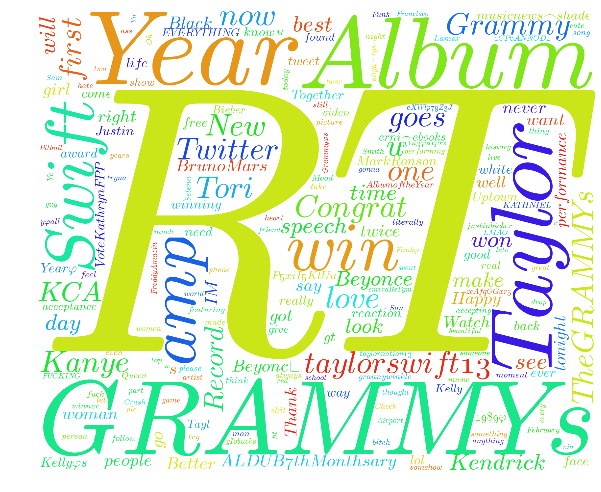

In [110]:
from wordcloud import WordCloud, STOPWORDS
newSTOP = STOPWORDS
# add stopwords to exclude from wordcloud - 
newSTOP.update(('co','https','t','RT','R','T'))

#generate wordcloud
wordcloud = WordCloud(font_path='/anaconda/envs/eq_env/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf',
                          stopwords=newSTOP,
                          background_color='white',
                          width=1700,
                          height=1400
                         ).generate(joined)
# display wordcloud
plt.imshow(wordcloud)
plt.axis('off')
plt.show();